# Freeze Bert Model Using CLS Token
### **Genre Label:14**
### **Data: Unbalance || expand_genre**
### **Bert Model: Case**

In [ ]:
#@title Installs
!pip install pydot --quiet
!pip install gensim --quiet
!pip install tensorflow==2.15.0 --quiet #15 13
!pip install tf_keras==2.15.0 --quiet
!pip install tensorflow-datasets==4.8 --quiet #8
!pip install tensorflow-text==2.15.0 --quiet #15
!pip install transformers==4.17 --quiet #4.40.2 #4.37.2

In [ ]:
import pandas as pd
import numpy as np
import os
import time
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from collections import Counter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from collections import Counter

# Loading the Dataset and Encoding the Text

# Bert Model

In [ ]:
from transformers import BertTokenizer, TFBertModel
import torch

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
MAX_SEQUENCE_LENGTH = 250

In [ ]:
expand_genre_train = pd.read_pickle('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/expand_genre_train_df.pkl')
expand_genre_val = pd.read_pickle('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/expand_genre_validation_df.pkl')
expand_genre_test = pd.read_pickle('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/expand_genre_test_df.csv.pkl')

In [ ]:
expand_genre_train.head()

,id,genres,tags,lang,artist,song,album_name,spotify_id,popularity,release,...,key,mode,valence,tempo,duration_ms,mapped_genres,lyrics_id,lyrics,updated_genre,broad_genre
2945,vaTUDcCwxbKUj72o,[pop],"[sampling, the cranberries, zombie, pop]",en,Eminem,In Your Head,Revival,5qykEZTHAcplCLrynoLRnN,60.0,2017,...,1.0,1.0,0.252,82.918,182640,Pop,vaTUDcCwxbKUj72o,"What's in your head, in your head\nZombie, zom...",pop,Pop
29804,0rYt4Pks3wZM7axD,[rap],"[shawnna, hip-hop, rap, female rap]",en,Shawnna,Gettin' Some,Block Music,4uNisev7PGUAixBOagpgyY,39.0,2006,...,4.0,0.0,0.648,78.059,202760,Hip Hop & Rap,0rYt4Pks3wZM7axD,"Gettin', gettin', gettin'\n\nI was gettin' som...",rap,Hip Hop & Rap
36641,K3XPiN69md8ss0N5,"[rap, west coast rap]","[hip-hop, rap, gangsta rap, 2pac, west coast rap]",en,2Pac,Ambitionz az a Ridah,All Eyez On Me,3ssX20QT5c3nA9wk78V1LQ,74.0,1996,...,2.0,1.0,0.805,87.279,278387,Hip Hop & Rap,K3XPiN69md8ss0N5,"I won't deny it, I'm a straight ridah\nYou don...",rap,Hip Hop & Rap
50376,HDdHAn6CFbKOsme4,[rock],"[rock, alternative, american, fav, 2017, tess]",en,The War on Drugs,Pain,A Deeper Understanding,59P1nrdEImkAKa1nyW9X2e,57.0,2017,...,7.0,0.0,0.482,115.975,330760,Rock,HDdHAn6CFbKOsme4,Go to bed now I can tell\nPain is on the way o...,rock,Rock
20136,FhG1z1oOGeize5ny,"[pop, eurodance]","[pop, 90s, dance, eurodance]",en,Ace of Base,Happy Nation,The Sign (US Album) [Remastered],7fb22pjF62S9r1s1pian5K,46.0,1993,...,1.0,1.0,0.670,96.049,255413,Pop,FhG1z1oOGeize5ny,Laudate omnes gentes laudate\nMagnificat en se...,pop,Pop


In [ ]:
# getting the text and tables from train, validation and test
expand_train_text = expand_genre_train['lyrics'].tolist()
expand_validation_text = expand_genre_val['lyrics'].tolist()
expand_test_text = expand_genre_test['lyrics'].tolist()

expand_train_label = expand_genre_train['broad_genre'].tolist()
expand_validation_label = expand_genre_val['broad_genre'].tolist()
expand_test_label = expand_genre_test['broad_genre'].tolist()

In [ ]:
# getting rid of \n in the lyrics column
def preprocess_text(text):
  return text.replace('\n', ' ')

expand_train_text = [preprocess_text(text) for text in expand_train_text]
expand_validation_text = [preprocess_text(text) for text in expand_validation_text]
expand_test_text = [preprocess_text(text) for text in expand_test_text]


In [ ]:
# encoding the labels
expand_encode_label = LabelEncoder()
expand_train_label = expand_encode_label.fit_transform(expand_train_label)
expand_validation_label = expand_encode_label.transform(expand_validation_label)
expand_test_label = expand_encode_label.transform(expand_test_label)

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features= 10000)

# fit and transform the text
X_train_expand = tfidf_vectorizer.fit_transform(expand_train_text)
X_val_expand = tfidf_vectorizer.transform(expand_validation_text)
X_test_expand = tfidf_vectorizer.transform(expand_test_text)

### Tokenize dataset with expanded genre label

In [ ]:
word_len = [len(w.split()) for w in expand_train_text]

sum(word_len) / len(word_len)

248.08624702852615

In [ ]:
#training
expand_train_tokenized = bert_tokenizer(expand_train_text,
                                        max_length=MAX_SEQUENCE_LENGTH,
                                        truncation=True,
                                        padding='max_length',
                                        return_tensors='tf')
expand_train_inputs = [expand_train_tokenized.input_ids, expand_train_tokenized.token_type_ids, expand_train_tokenized.attention_mask]
expand_train_labels = np.array(expand_train_label)

#validation
expand_val_tokenized = bert_tokenizer(expand_validation_text,
                                      max_length=MAX_SEQUENCE_LENGTH,
                                      truncation=True,
                                      padding='max_length',
                                      return_tensors='tf')
expand_val_inputs = [expand_val_tokenized.input_ids, expand_val_tokenized.token_type_ids, expand_val_tokenized.attention_mask]
expand_val_labels = np.array(expand_validation_label)

#test
expand_test_tokenized = bert_tokenizer(expand_test_text,
                                       max_length=MAX_SEQUENCE_LENGTH,
                                       truncation=True, padding='max_length',
                                       return_tensors='tf')
expand_test_inputs = [expand_test_tokenized.input_ids, expand_test_tokenized.token_type_ids, expand_test_tokenized.attention_mask]
expand_test_labels = np.array(expand_test_label)


In [ ]:
print("Expand Train input IDs shape:", expand_train_inputs[0].shape)
print("Expand Validation input IDs shape:", expand_val_inputs[0].shape)
print("Expand Test input IDs shape:", expand_test_inputs[0].shape)
print("First tokenized expand train input:", expand_train_inputs[0][0])
print("First tokenized expand validation input:", expand_val_inputs[0][0])
print("First tokenized expand test input:", expand_test_inputs[0][0])

Expand Train input IDs shape: (40384, 250)
Expand Validation input IDs shape: (5048, 250)
Expand Test input IDs shape: (5048, 250)
First tokenized expand train input: tf.Tensor(
[  101  1327   112   188  1107  1240  1246   117  1107  1240  1246 25249
   117 16192   117 16192   118   178  1162   118   178  1162  1327   112
   188  1107  1240  1246   117  1107  1240  1246 25249   117 16192   117
 16192   118   178  1162   118   178  1162   117  9294   146   112   182
  5246  1394   112  1146  1139  4170   117  1112  1277  4170  1107  1103
  1610  1112   146  1169  4218  1262   146   112   182  1198   173  2047
  6871   112  1112  1677  1112   146  1169  1243  9252  1121  1292  2645
   112 27216  1155  1104  1139 17359  1116   146  5042  1327   112   188
  4911  1176   136   112 20111  3568   146   112   182  1838  1394   112
  1297  1254  3949  1106  1103  2655  1105  1831   117  9367  1821   146
 23831   112   136  4981 15604 21155  1186  1165   146  5442 10401  3708
  1838  1394   112 

In [ ]:
#@title Freeze Bert Classification Model using CLS

def freeze_bert_model_with_CLS(bert_base_model,
                          max_sequence_length=MAX_SEQUENCE_LENGTH,
                          hidden_size = 100,
                          dropout=0.3,
                          learning_rate=2e-5,
                          last_layer_num=11,
                          num_classes=14
                       ):
    # freezing all bert layers except the last transformer block
    for w in bert_base_model.weights:
        if f'layer_._{last_layer_num}' not in w.name and 'pooler' not in w.name:
            w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_base_model(bert_inputs)

    cls_token = bert_out[0][:, 0, :]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    classification = tf.keras.layers.Dense(num_classes, activation='softmax', name='classification_layer')(hidden)
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0),
                                 loss='sparse_categorical_crossentropy',
                                 metrics=['accuracy'])
    return classification_model

In [ ]:
num_classes = 14
checkpoint_dir = '/content/drive/MyDrive/w266/266 Final Project/model_checkpoints/'
bert_last_layer_num = 11

In [ ]:
bert_model_3 = freeze_bert_model_with_CLS(
    bert_model,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    hidden_size=100,
    dropout=0.3,
    learning_rate=2e-5,
    last_layer_num=bert_last_layer_num,
    num_classes = num_classes
)

bert_model_3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 250)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 250)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 250)]                0         []                            
 tLayer)                                                                                      

In [ ]:
#calculate sample weights
sample_weight = np.ones(shape=(len(expand_train_labels),))
for label in range(np.max(expand_train_labels) + 1):
    class_weight = 1 - np.sum(expand_train_labels == label) / len(expand_train_labels)
    sample_weight[expand_train_labels == label] = class_weight

# setting up check points
checkpoint_prefix = checkpoint_dir + 'bert_weights_%s'
checkpoint_filepath = checkpoint_prefix + '.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True
)

In [ ]:
bert_model_3_history = bert_model_3.fit(
    expand_train_inputs,
    expand_train_labels,
    sample_weight=sample_weight,
    validation_data=(expand_val_inputs, expand_val_labels),
    epochs=3,
    batch_size = 8,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/3
5048/5048 [==============================] - 1047s 207ms/step - loss: 1.6711 - accuracy: 0.3499 - val_loss: 1.6561 - val_accuracy: 0.4261
Epoch 2/3
5048/5048 [==============================] - 1001s 198ms/step - loss: 1.4904 - accuracy: 0.4100 - val_loss: 1.5998 - val_accuracy: 0.4376
Epoch 3/3
5048/5048 [==============================] - 1005s 199ms/step - loss: 1.4287 - accuracy: 0.4340 - val_loss: 1.5783 - val_accuracy: 0.4531


In [ ]:
val_predictions = bert_model_3.predict(expand_val_inputs)
val_predictions = np.argmax(val_predictions, axis=1)
print(classification_report(expand_val_labels, val_predictions, target_names=expand_encode_label.classes_))

158/158 [==============================] - 96s 590ms/step
                precision    recall  f1-score   support

   Alternative       0.60      0.02      0.03       182
     Classical       0.00      0.00      0.00         2
       Country       0.55      0.26      0.35       107
    Electronic       0.37      0.21      0.27       510
          Folk       0.41      0.15      0.22       402
 Hip Hop & Rap       0.87      0.74      0.80       247
          Jazz       0.56      0.14      0.22        73
         Latin       0.00      0.00      0.00         4
         Metal       0.59      0.72      0.65       500
           Pop       0.44      0.67      0.53       968
          Punk       0.40      0.28      0.33       490
        Reggae       0.00      0.00      0.00        12
Rhythm & Blues       0.46      0.08      0.14       237
          Rock       0.39      0.56      0.46      1314

      accuracy                           0.45      5048
     macro avg       0.40      0.27      0.2

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


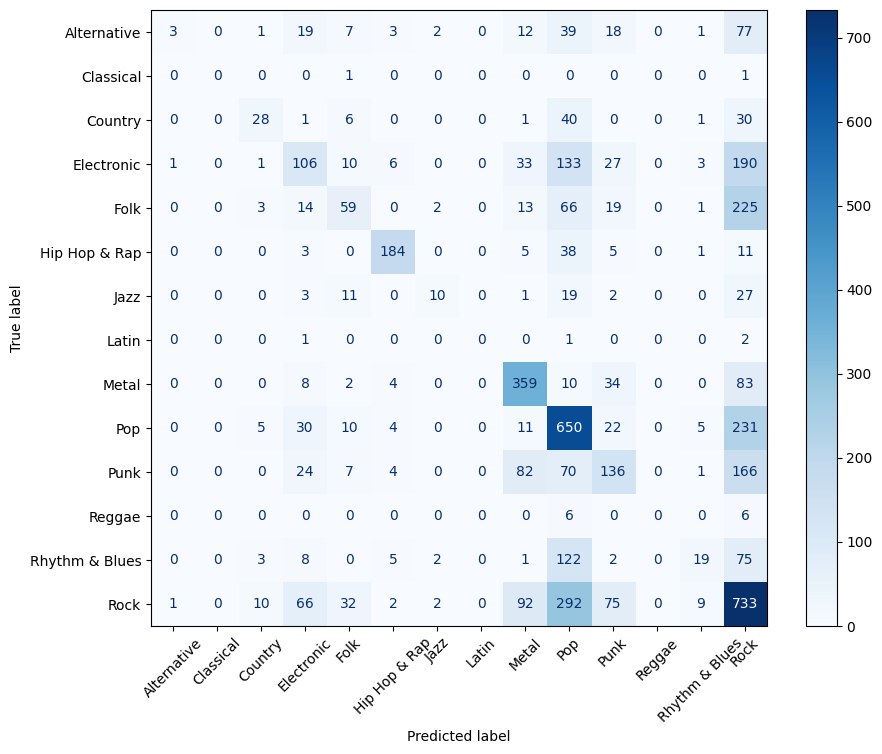

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(expand_val_labels, val_predictions)
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=expand_encode_label.classes_)
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')
plt.xticks(rotation=45)
plt.show()